In [1]:
# import zipfile
# with zipfile.ZipFile("/home/mira1/vlex_mira/acad/data_processed.zip", 'r') as zip_ref:
#     zip_ref.extractall("/home/mira1/vlex_mira/acad/")


## Feature extraction

In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pdc
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import time
import copy
import timm
from prettytable import PrettyTable

import logging
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter
this_path = Path().resolve()

import pandas as pd

In [2]:
binary_data = this_path.parent.parent/'data_processed/binary/'
models_path = this_path.parent.parent/'models/binary/'


In [3]:
experiment_no = 'exp15-4-3-3mlp'
network_arch = 'swin_t'

experiment_path = models_path/network_arch/experiment_no
experiment_path.mkdir(parents=True, exist_ok=True)

cfg = {
    'data': {
        'exp_name' : network_arch + '/' + experiment_no,
        'data_dir' : binary_data,
        'chkpt_path' : experiment_path,
        'best_model_path' : experiment_path/"best_model.pt",
        'tensorboard_path' : models_path/'tensorboard/',
        },
    'train': {
        'epochs' : 50,
        'batch_size' : 40,
        'lr' : 0.001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'sch_patience': 6,
        'sch_thresh': 0.001,
        'es_patience': 15,
        'es_delta': 0.02,
        'cuda': 'cuda:1',
        'optimizer': 'sgd'
        },
    'val': {
        'batch_size' : 40,
        'num_workers' : 2,
        }
}


# cfg = {
#     'data': {
#         'data_dir' : binary_data,
#         'chkpt_path' : models_path,
#         'best_model_path' : models_path + "best_model.pt",
#         'tensorboard_path' : models_path + "tensorboard/",
#         },
#     'train': {
#         'epochs' : 25,
#         'batch_size' : 20,
#         'lr' : 0.001,
#         'momentum' : 0.9,
#         'weight_decay' : 0.0005,
#         'num_workers' : 4,
#         'lr_step_size' : 7,
#         'gamma' : 0.1,
#         },
#     'val': {
#         'batch_size' : 5,
#         'num_workers' : 4,
#         }
# }

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0, 90), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomAutocontrast(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize([0.7214, 0.5728, 0.5652], [0.1402, 0.1548, 0.1724])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.7214, 0.5728, 0.5652], [0.1402, 0.1548, 0.1724])
    ]),
}


datasets = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms[x])
            for x in ['train', 'val']}
            
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

class_names = datasets['train'].classes

device = torch.device(cfg['train']['cuda'] if torch.cuda.is_available() else "cpu") # "cpu"


In [5]:
dataloaders = {
        'val': DataLoader(
            datasets['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=False),
        'train': DataLoader(
            datasets['train'], batch_size=cfg['train']['batch_size'],
            shuffle=True, num_workers=cfg['val']['num_workers'], drop_last=False)
    }

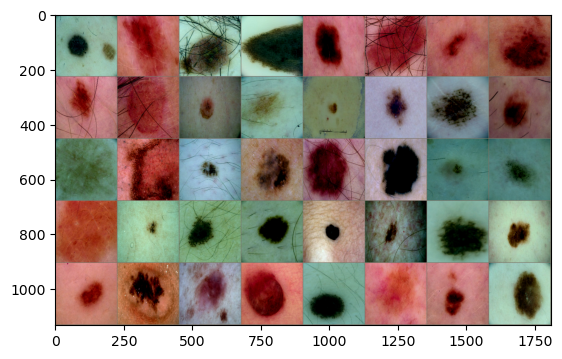

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

### Create model and set it as feature extractor

In [8]:
class FeatureExtractor(nn.Module):
    # for swin model with child names: features, norm, permute, avgpool, flatten, head
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract model Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract all layers
    self.norm = model.norm
    self.permute = model.permute
    self.pooling = model.avgpool
    self.flatten = model.flatten
      
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.norm(out)
    out = self.permute(out)
    out = self.pooling(out)
    out = self.flatten(out)
    out = F.avg_pool1d(out, kernel_size=3)
    return out 

# for child in model_ft.children():
#     print(child)

In [9]:
# Create model and load state dict

filename = models_path/'swin_t/exp15-4-3/best_model.pt'

model_ft = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Linear(num_ftrs, 2)

best_model_ckpt = torch.load(filename)
model_ft.load_state_dict(best_model_ckpt['model_state_dict'])


new_model = FeatureExtractor(model_ft)
new_model = new_model.to(device)


In [23]:
def extract_features(data_dl, model, phase):
    model.eval() 
        
    with torch.no_grad():
        features = None
        labels_list = []       

        for inputs, labels in data_dl[phase]:

            inputs = inputs.to(device)
            output = model(inputs)
    
            if features is not None:
                features = torch.cat((features, output), 0)
            else:
                features = output

            labels_list.extend(labels.cpu().numpy())

        features = features.view(features.size(0), -1)        
        feat_df = pd.DataFrame(features.cpu().numpy(), 
                                columns=[f'f_{n}' for n in range(features.size(-1))])
        feat_df = feat_df.fillna(0)
        feat_df['label'] = labels_list
    
    return feat_df

In [24]:
df_train = extract_features(dataloaders, new_model, 'train')
df_val = extract_features(dataloaders, new_model, 'val')
df_train['phase'] = 'train'
df_val['phase'] = 'val'
train_shape = df_train.shape
val_shape = df_val.shape
print(f'train shape: {train_shape}, val shape: {val_shape}')

train shape: (15195, 258), val shape: (3796, 258)


In [25]:
df = pd.concat([df_train, df_val])
df

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,label,phase
0,0.112043,0.087118,0.021181,0.031114,-0.065670,0.007880,0.024739,-0.205424,0.105830,0.055208,...,-0.032561,0.224773,-0.056181,0.261515,-0.091653,-0.053979,-0.016110,-0.036370,0,train
1,0.559299,0.587215,0.498947,-0.084989,-0.505924,0.036934,-0.198580,0.311258,0.221563,0.613553,...,-0.200288,0.840240,0.232592,1.029955,-0.328323,-0.654088,0.403248,-0.121361,0,train
2,-0.008274,-0.082201,-0.120258,0.006084,0.092706,-0.087430,-0.000430,-0.251677,0.092663,0.000340,...,0.066300,-0.141789,-0.063999,0.154327,0.079216,0.049004,0.072067,-0.019224,1,train
3,-0.128612,-0.242171,-0.038727,-0.021892,0.034205,-0.097371,-0.086361,-0.185710,0.103222,-0.030369,...,0.209466,-0.286222,-0.027109,-0.060680,0.116930,0.093687,-0.084908,0.019315,1,train
4,-0.361916,-0.594593,-0.181693,-0.125695,0.374965,-0.174488,-0.011748,-0.148112,0.322629,-0.410099,...,0.567236,-0.811132,0.048965,-0.430353,0.097273,0.223243,0.072624,0.008047,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,-0.075762,-0.503211,-0.172670,-0.155227,-0.000541,0.016901,0.218259,0.074330,0.126630,0.058027,...,0.093962,-0.518382,-0.150343,-0.409661,0.150508,0.257491,-0.144667,0.290438,1,val
3792,-0.020646,-0.423505,-0.013561,-0.131943,0.101779,-0.113388,-0.068973,-0.121251,0.225393,-0.097432,...,0.132647,-0.485825,0.004772,-0.350677,0.112066,0.081115,-0.063919,0.066254,1,val
3793,-0.155923,-0.778444,0.157174,-0.048668,0.204543,-0.033202,0.390384,-0.011915,0.130065,-0.196837,...,0.109810,-0.712822,0.040249,-0.472790,0.181652,0.558856,-0.245008,0.312715,1,val
3794,-0.009737,-0.062709,0.018843,0.030231,-0.102336,0.031096,-0.045647,-0.007841,0.058540,0.072421,...,-0.036094,0.032373,-0.055885,0.203587,-0.120968,-0.051966,-0.071666,0.175317,1,val


In [ ]:
# df.reset_index().to_feather(models_path/'swin_t/exp15-4-3/train_val_swin_exp15-4-3.f')

## SVM classifier

In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import time

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn import svm

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel


this_path = Path().resolve()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
binary_data = this_path.parent.parent/'data_processed/binary/'
models_path = this_path.parent.parent/'models/binary/'

In [3]:
df = pd.read_feather(models_path/'swin_t/exp15-4-3/train_val_swin_exp15-4-3.f')
df.drop('index', axis=1, inplace=True)
train_f = df.loc[df.phase == 'train', :]
val_f = df.loc[df.phase == 'val', :]
train_shape = train_f.shape
val_shape = val_f.shape
df

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,label,phase
0,0.112043,0.087118,0.021181,0.031114,-0.065670,0.007880,0.024739,-0.205424,0.105830,0.055208,...,-0.032561,0.224773,-0.056181,0.261515,-0.091653,-0.053979,-0.016110,-0.036370,0,train
1,0.559299,0.587215,0.498947,-0.084989,-0.505924,0.036934,-0.198580,0.311258,0.221563,0.613553,...,-0.200288,0.840240,0.232592,1.029955,-0.328323,-0.654088,0.403248,-0.121361,0,train
2,-0.008274,-0.082201,-0.120258,0.006084,0.092706,-0.087430,-0.000430,-0.251677,0.092663,0.000340,...,0.066300,-0.141789,-0.063999,0.154327,0.079216,0.049004,0.072067,-0.019224,1,train
3,-0.128612,-0.242171,-0.038727,-0.021892,0.034205,-0.097371,-0.086361,-0.185710,0.103222,-0.030369,...,0.209466,-0.286222,-0.027109,-0.060680,0.116930,0.093687,-0.084908,0.019315,1,train
4,-0.361916,-0.594593,-0.181693,-0.125695,0.374965,-0.174488,-0.011748,-0.148112,0.322629,-0.410099,...,0.567236,-0.811132,0.048965,-0.430353,0.097273,0.223243,0.072624,0.008047,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18986,-0.075762,-0.503211,-0.172670,-0.155227,-0.000541,0.016901,0.218259,0.074330,0.126630,0.058027,...,0.093962,-0.518382,-0.150343,-0.409661,0.150508,0.257491,-0.144667,0.290438,1,val
18987,-0.020646,-0.423505,-0.013561,-0.131943,0.101779,-0.113388,-0.068973,-0.121251,0.225393,-0.097432,...,0.132647,-0.485825,0.004772,-0.350677,0.112066,0.081115,-0.063919,0.066254,1,val
18988,-0.155923,-0.778444,0.157174,-0.048668,0.204543,-0.033202,0.390384,-0.011915,0.130065,-0.196837,...,0.109810,-0.712822,0.040249,-0.472790,0.181652,0.558856,-0.245008,0.312715,1,val
18989,-0.009737,-0.062709,0.018843,0.030231,-0.102336,0.031096,-0.045647,-0.007841,0.058540,0.072421,...,-0.036094,0.032373,-0.055885,0.203587,-0.120968,-0.051966,-0.071666,0.175317,1,val


In [4]:
df_train = train_f.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_f.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
print(f"df_train: {df_train.shape}, df_val: {df_val.shape}")

df_train: (15195, 258), df_val: (3796, 258)


In [5]:
X_train, y_train = df_train.iloc[:, :(train_shape[1]-2)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-2)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-2)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-2)].to_numpy()
print('Data balancing: ')
print(f'train: {np.unique(y_train, return_counts=True)}, val: {np.unique(y_test, return_counts=True)}')

Data balancing: 
train: (array([0, 1]), array([7725, 7470])), val: (array([0, 1]), array([1931, 1865]))


In [6]:
X_train.shape

(15195, 256)

In [7]:
# SVM -- without feature selection
param_grid = {'classifier__C': [0.1, 1, 10, 100],
              'classifier__gamma': [1, 0.1, 0.01, 0.001],
              'classifier__kernel': ['rbf', 'linear', 'poly']}

# param_grid = {'classifier__C': [1],
#               'classifier__gamma': [0.1],
#               'classifier__kernel': ['rbf']}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
classifier = svm.SVC()
pipe = Pipeline([('classifier', classifier)])
grid_search = GridSearchCV(pipe, param_grid, cv=cv, refit = True, verbose = 1)
grid_search.fit(X_train, y_train)
print("TRAIN- The best parameters are %s with an accuracy of %0.4f"%(grid_search.best_params_, grid_search.best_score_))
y_train_predicted = grid_search.predict(X_train)
y_test_predicted =  grid_search.predict(X_test)
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='macro'), f'Acc: {accuracy_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='macro'), f'Acc: {accuracy_score(y_test, y_test_predicted)}')

Fitting 10 folds for each of 48 candidates, totalling 480 fits
TRAIN- The best parameters are {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'} with an accuracy of 0.9206
F1 Score of train data: 0.9228 Acc: 0.9229351760447516
F1 Score of test data: 0.8841 Acc: 0.8843519494204426


## Swin as FE with MLP

In [11]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
        
def train_model(model, criterion, optimizer, scheduler, writer, early_stopper, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    last_three_losses = []
    early_stopping_count = 0
    previous_mean_loss = 0


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'val':
                scheduler.step(epoch_loss)
                # print(f"Last LR: {optimizer.param_groups[0]['lr']} --- ")

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalars('acc',{f'{phase}': epoch_acc}, epoch+1)
            writer.add_scalars('loss',{f'{phase}': epoch_loss}, epoch+1)

            # save last and best checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'configuration': cfg,
                'loss': epoch_loss}, cfg['data']['chkpt_path']/f'last_checkpoint_{epoch}.pt')


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                best_metric = best_acc
                
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'metrics': best_metric,
                    'configuration': cfg
                    }, cfg['data']['best_model_path'])

        if phase == 'val':
            if early_stopper.early_stop(epoch_loss):
                print(f'Training stopped at epoch {epoch}')             
                break
                
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [7]:
# load model and weights
filename = models_path/'swin_t/exp15-4-3/best_model.pt'

model_ft = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Linear(num_ftrs, 2)

best_model_ckpt = torch.load(filename)
model_ft.load_state_dict(best_model_ckpt['model_state_dict'])

# set as FE
for param in model_ft.parameters():
    param.requires_grad = False

# Create new head for classification
model_ft.head = nn.Sequential(
                        nn.Linear(num_ftrs, 512),
                        nn.ReLU(),
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Linear(256, 2)
                        )
model_ft = model_ft.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()

if cfg['train']['optimizer'] == 'adam':
    optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
else:
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)

In [12]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
print(logdir)
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=cfg['train']['es_patience'], min_delta=cfg['train']['es_delta'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

/home/mira1/vlex_mira/acad/models/binary/tensorboard/swin_t/exp15-4-3-3mlp
Epoch 0/49
----------
train Loss: 0.3236 Acc: 0.8845
val Loss: 0.3201 Acc: 0.8688

Epoch 1/49
----------
train Loss: 0.2584 Acc: 0.8935
val Loss: 0.3206 Acc: 0.8693

Epoch 2/49
----------
train Loss: 0.2558 Acc: 0.8957
val Loss: 0.3219 Acc: 0.8693

Epoch 3/49
----------
train Loss: 0.2519 Acc: 0.8945
val Loss: 0.3240 Acc: 0.8691

Epoch 4/49
----------
train Loss: 0.2579 Acc: 0.8929
val Loss: 0.3235 Acc: 0.8675

Epoch 5/49
----------
train Loss: 0.2529 Acc: 0.8944
val Loss: 0.3224 Acc: 0.8709

Epoch 6/49
----------
train Loss: 0.2575 Acc: 0.8935
val Loss: 0.3226 Acc: 0.8704

Epoch 7/49
----------
train Loss: 0.2566 Acc: 0.8931
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
val Loss: 0.3208 Acc: 0.8709

Epoch 8/49
----------
train Loss: 0.2558 Acc: 0.8912
val Loss: 0.3206 Acc: 0.8714

Epoch 9/49
----------
train Loss: 0.2536 Acc: 0.8950
val Loss: 0.3205 Acc: 0.8712

Epoch 10/49
----------
train Loss